In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("./Copper_Set.csv", low_memory=False, encoding='unicode_escape')
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.15113862,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.0248392,30202938.0,25.0,Won,W,41.0,0.80,1210.0,104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.1279489,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.4110654,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.5262616,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [3]:
df.shape

(181673, 14)

In [4]:
df.isnull().sum()

id                   2
item_date            1
quantity tons        0
customer             1
country             28
status               2
item type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery date        1
selling_price        1
dtype: int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
item_date,181672.0,2.020459e+07,4.551119e+03,19950000.00,20200929.0,20201130.0,2.021020e+07,2.021040e+07
customer,181672.0,3.051221e+07,2.433382e+07,12458.00,30196884.0,30205242.0,3.028042e+07,2.147484e+09
country,181645.0,4.489302e+01,2.440421e+01,25.00,26.0,30.0,7.800000e+01,1.130000e+02
application,181649.0,2.561581e+01,1.775417e+01,2.00,10.0,15.0,4.100000e+01,9.900000e+01
thickness,181672.0,2.564827e+00,6.572321e+00,0.18,0.7,1.5,3.000000e+00,2.500000e+03
width,181673.0,1.295287e+03,2.616318e+02,1.00,1180.0,1250.0,1.500000e+03,2.990000e+03
product_ref,181673.0,4.739679e+08,7.175101e+08,611728.00,611993.0,640665.0,1.332077e+09,1.722208e+09
delivery date,181672.0,2.020738e+07,2.411059e+04,20190401.00,20201101.0,20210101.0,2.021040e+07,3.031010e+07
selling_price,181672.0,1.918036e+03,3.317956e+05,-1160.00,669.0,812.0,9.530000e+02,1.000010e+08


In [6]:
df.dtypes

id                object
item_date        float64
quantity tons     object
customer         float64
country          float64
status            object
item type         object
application      float64
thickness        float64
width            float64
material_ref      object
product_ref        int64
delivery date    float64
selling_price    float64
dtype: object

In [7]:
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date

In [8]:
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['customer'] = pd.to_numeric(df['customer'], errors='coerce')
#df['country'] = df['country'].astype(int)

In [9]:
df['status'].value_counts()

Won                116010
Lost                34438
Not lost for AM     19573
Revised              4276
To be approved       4170
Draft                3140
Offered                53
Offerable              10
Wonderful               1
Name: status, dtype: int64

In [10]:
#define list of values
values = ['Not lost for AM', 'Revised', 'To be approved', 'Draft', 'Offered', 'Offerable', 'Wonderful']

#drop any rows that have 7 or 11 in the rebounds column
df = df[df.status.isin(values) == False]

In [11]:
df.status.value_counts()

Won     116010
Lost     34438
Name: status, dtype: int64

In [12]:
df.shape

(150450, 14)

In [13]:
df['item type'].value_counts()

W         91956
S         52467
PL         5032
WI          504
Others      463
IPL          27
SLAWR         1
Name: item type, dtype: int64

In [14]:
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,104991,1668701718,2021-04-01,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,2021-04-01,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,2021-01-01,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,2021-04-01,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,2021-03-01,577.00


In [15]:
df = df[~df['material_ref'].astype(str).str.startswith('00000')].reset_index()

In [16]:
df.shape

(150414, 15)

<AxesSubplot: >

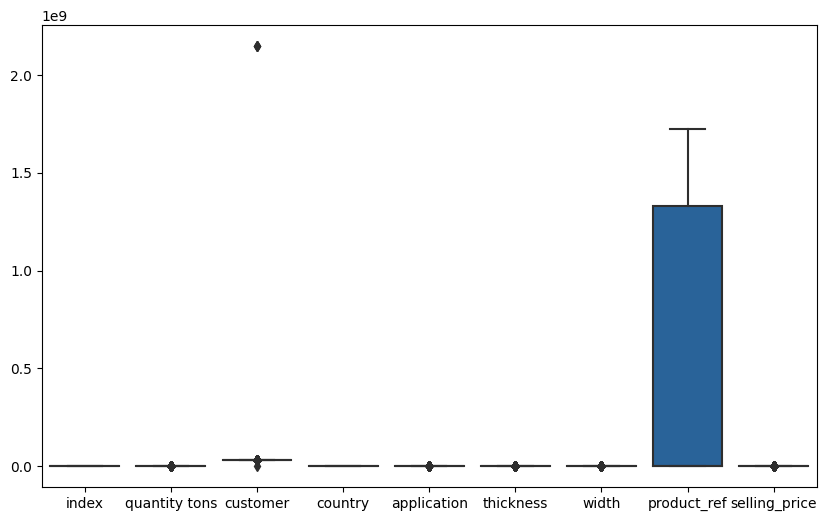

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, palette='Blues')

In [18]:
df.isnull().sum()

index                0
id                   1
item_date            3
quantity tons        1
customer             1
country              4
status               2
item type            0
application          3
thickness            0
width                0
material_ref     62799
product_ref          0
delivery date        2
selling_price        1
dtype: int64

In [19]:
df['material_ref'] = df['material_ref'].fillna(df['material_ref'].mode()[0])

In [20]:
df = df.dropna()

In [21]:
df.isnull().sum()

index            0
id               0
item_date        0
quantity tons    0
customer         0
country          0
status           0
item type        0
application      0
thickness        0
width            0
material_ref     0
product_ref      0
delivery date    0
selling_price    0
dtype: int64

In [22]:
df.shape

(150399, 15)

In [23]:
df.describe()

,index,quantity tons,customer,country,application,thickness,width,product_ref,selling_price
count,150399.000000,150399.000000,1.503990e+05,150399.000000,150399.000000,150399.000000,150399.000000,1.503990e+05,150399.000000
mean,90659.400481,94.465385,3.023290e+07,45.382935,25.191198,2.618798,1297.856285,4.749299e+08,825.758957
std,52489.990126,441.000351,1.056172e+05,24.485859,17.640318,7.116487,266.185905,7.173408e+08,290.917546
min,0.000000,-2000.000000,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,-1160.000000
25%,45742.500000,10.699438,3.019689e+07,26.000000,10.000000,0.740000,1176.000000,6.283770e+05,671.000000
50%,89889.000000,29.935575,3.020531e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,811.000000
75%,136079.500000,64.871553,3.027982e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,951.000000
max,181672.000000,70252.363070,3.040818e+07,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,81236.140000


In [24]:
df.shape

(150399, 15)

In [25]:
df.head()

,index,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00
1,1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,104991,1668701718,2021-04-01,1047.00
2,2,E140FF1B-2407-4C02-A0DD-780A093B1158,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33
3,3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,2021-04-01,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,2021-01-01,768.00
4,4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,2021-04-01,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,2021-03-01,577.00


In [26]:
Q1 = df['thickness'].quantile(0.25)
Q3 = df['thickness'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(lower_limit, upper_limit)

df = df[(df['thickness']> lower_limit) & (df['thickness']< upper_limit)]

-2.6499999999999995 6.39


In [27]:
Q1 = df['width'].quantile(0.25)
Q3 = df['width'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(lower_limit, upper_limit)

df = df[(df['width']> lower_limit) & (df['width']< upper_limit)]

720.0 1904.0


In [28]:
Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(lower_limit, upper_limit)

df = df[(df['selling_price']> lower_limit) & (df['selling_price']< upper_limit)]

260.5 1392.5


In [29]:
Q1 = df['quantity tons'].quantile(0.25)
Q3 = df['quantity tons'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print(lower_limit, upper_limit)

df = df[(df['quantity tons']> lower_limit) & (df['quantity tons']< upper_limit)]

-74.6050273075 152.17009239249998


In [30]:
df.head()

,index,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0
6,7,AA3F18A2-A7D6-43DE-8644-F0632AE2CB68,2021-04-01,113.387124,30342192.0,32.0,Won,W,41.0,0.68,1220.0,1000944,611993,2021-01-01,931.0
7,8,2851F48B-DA32-4DF3-884B-17A3100DD65A,2021-04-01,69.071853,30341428.0,38.0,Won,S,10.0,0.60,1275.0,106786,1668701376,2021-07-01,1363.0
9,11,CA076845-2EDE-4C02-95BE-6C7B842026E8,2021-04-01,113.995666,30342192.0,32.0,Won,W,41.0,0.55,1220.0,1000063,611993,2021-01-01,954.0
10,12,EE7EE006-15B3-47A5-A48D-70D54C6B734C,2021-04-01,27.512545,30165529.0,78.0,Won,W,10.0,0.75,1250.0,DX51D+Z,164141591,2021-07-01,1098.0


In [31]:
df.shape

(114975, 15)

In [32]:
df.describe()

,index,quantity tons,customer,country,application,thickness,width,product_ref,selling_price
count,114975.000000,114975.000000,1.149750e+05,114975.000000,114975.000000,114975.000000,114975.000000,1.149750e+05,114975.000000
mean,91008.789876,35.536712,3.022918e+07,45.860326,25.398043,1.826221,1260.242161,4.797327e+08,839.341706
std,52186.641720,32.860020,1.135905e+05,24.685860,17.452852,1.453363,185.755666,7.130445e+08,190.700416
min,0.000000,-18.000000,1.245800e+04,25.000000,2.000000,0.180000,721.000000,6.117330e+05,396.000000
25%,46891.500000,9.335499,3.016599e+07,26.000000,10.000000,0.700000,1164.000000,6.119930e+05,687.835000
50%,91201.000000,27.188572,3.020506e+07,30.000000,15.000000,1.250000,1250.000000,6.406650e+05,829.880000
75%,135928.500000,51.737704,3.027215e+07,78.000000,41.000000,2.500000,1410.000000,1.332077e+09,970.000000
max,181670.000000,152.166734,3.040818e+07,113.000000,99.000000,6.350000,1900.000000,1.721130e+09,1392.000000


In [33]:
df['item type'].value_counts()

W         73767
S         38328
PL         2490
Others      278
WI           94
IPL          18
Name: item type, dtype: int64

In [34]:
df.head(2)

,index,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0
6,7,AA3F18A2-A7D6-43DE-8644-F0632AE2CB68,2021-04-01,113.387124,30342192.0,32.0,Won,W,41.0,0.68,1220.0,1000944,611993,2021-01-01,931.0


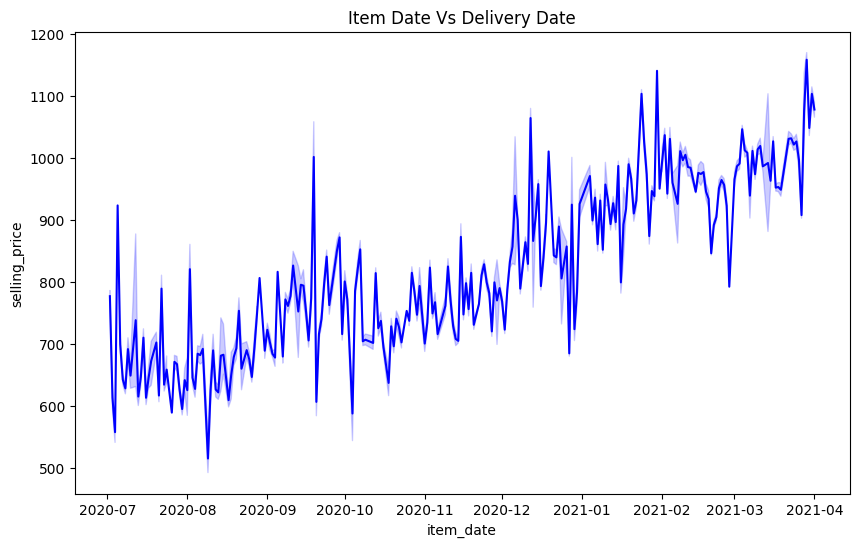

In [35]:
#plt.plot(x=df['item_date'], y=df['selling_price'])

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='item_date', y='selling_price', color='blue')

plt.title('Item Date Vs Delivery Date')
plt.show()

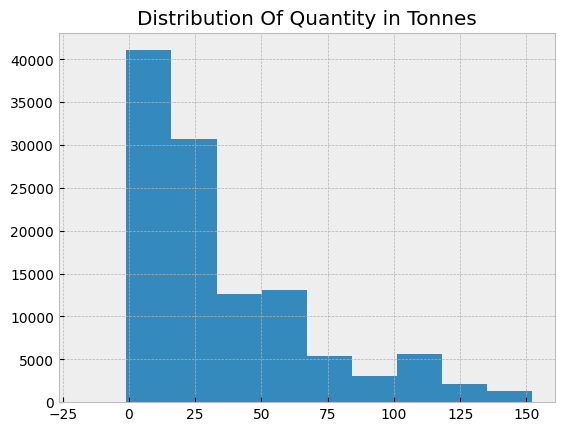

In [36]:
plt.style.use("bmh") #ggplot

plt.hist(x=df['quantity tons'])

plt.title("Distribution Of Quantity in Tonnes")
plt.show()

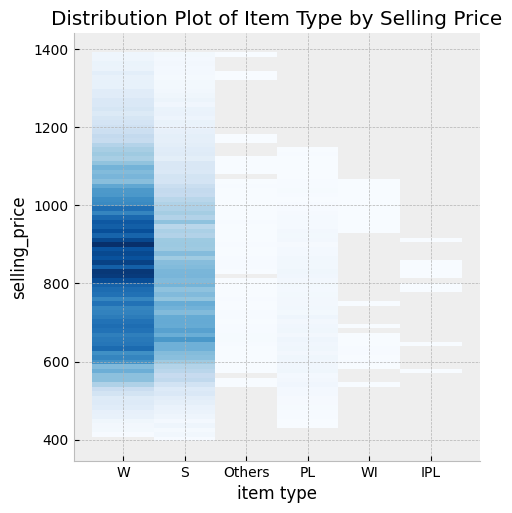

In [37]:
sns.displot(data=df, x='item type', y='selling_price', cmap='Blues')
plt.title("Distribution Plot of Item Type by Selling Price")
plt.show()

<AxesSubplot: xlabel='item type'>

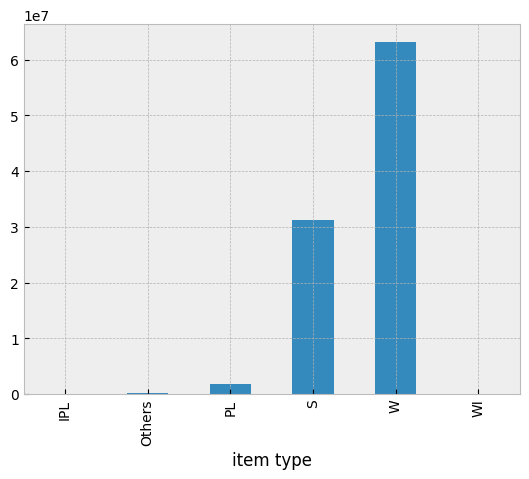

In [38]:
df.groupby('item type')['selling_price'].sum().plot(kind='bar')

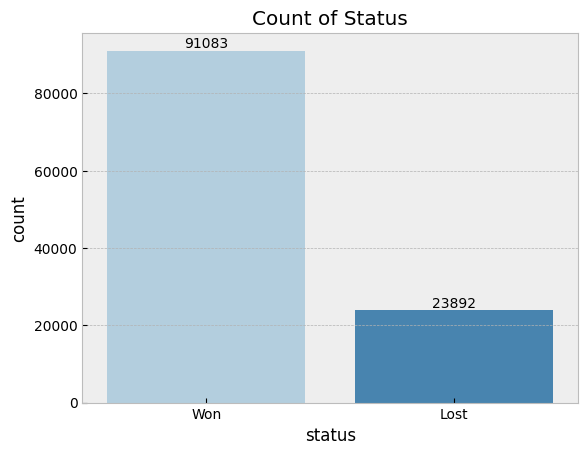

In [39]:
ax = sns.countplot(x=df['status'], palette='Blues')
for label in ax.containers:
    ax.bar_label(label)

plt.title("Count of Status")
plt.show()

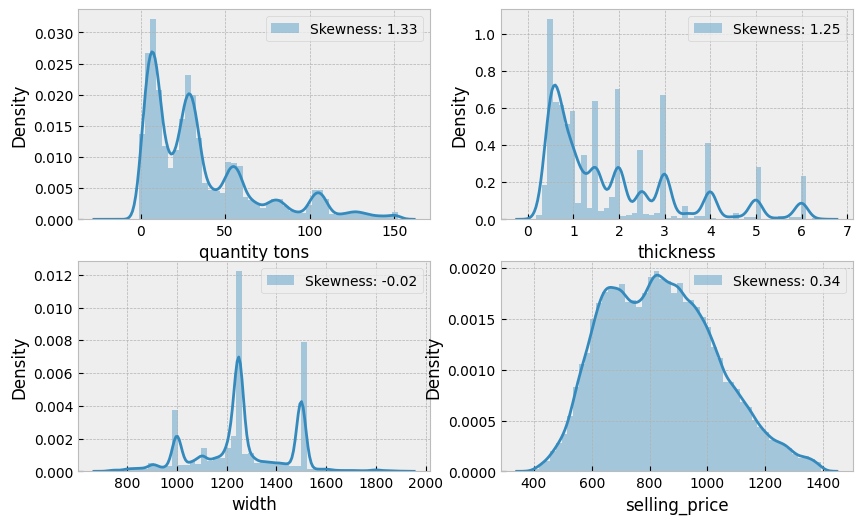

In [40]:
plt.figure(figsize=(10,6))

plt.subplot(221)
t=sns.distplot(df["quantity tons"],label="Skewness: %.2f"%(df["quantity tons"].skew()))
t.legend()

plt.subplot(222)
t=sns.distplot(df["thickness"],label="Skewness: %.2f"%(df["thickness"].skew()))
t.legend()

plt.subplot(223)
t=sns.distplot(df["width"],label="Skewness: %.2f"%(df["width"].skew()))
t.legend()

plt.subplot(224)
t=sns.distplot(df["selling_price"],label="Skewness: %.2f"%(df["selling_price"].skew()))
t.legend()

plt.show()

<AxesSubplot: >

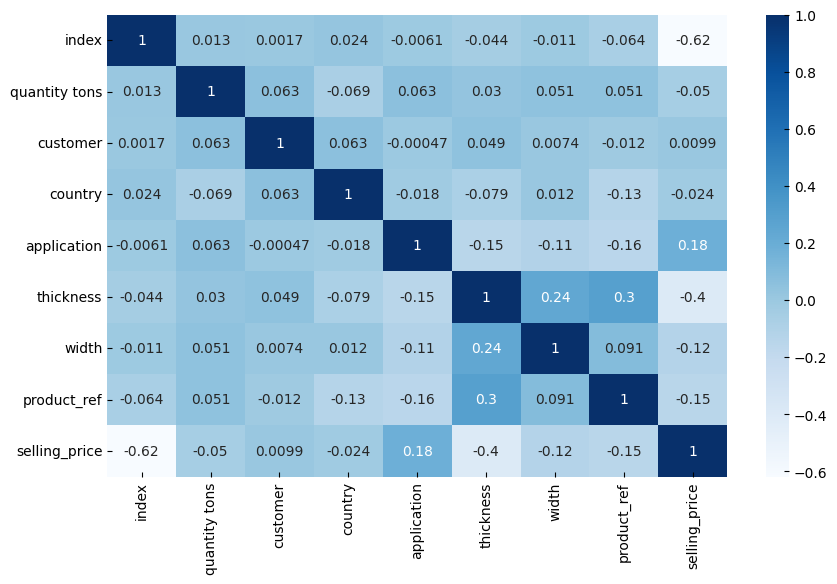

In [41]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='Blues')

# Classification Problem

In [42]:
X = df[['quantity tons', 'customer', 'country', 'item type', 'application', 'thickness', 'width', 'product_ref', 'selling_price']]
y = df['status']

In [43]:
X['item type'] = X['item type'].map({'IPL':0, 'WI':1, 'Others':2, 'PL':3, 'S':4, 'W':5})
y = y.map({'Lost':0, 'Won':1})

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

# Using RandomOverSampler for balance the target variable

ros = RandomOverSampler()
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)


counter = Counter(y_train)
print('Before', counter)

counter = Counter(y_train_ros)
print('After', counter)

##### Logistic Regression

In [46]:
log_model = LogisticRegression(class_weight='balanced')
log_model.fit(x_train, y_train)
y_pred_log = log_model.predict(x_test)

print("Confusion Matrix: ", '\n', confusion_matrix(y_test, y_pred_log))
print("Classification Report: ", '\n', classification_report(y_test, y_pred_log))
print("Roc_Auc_Score: ", '\n', roc_auc_score(y_test, y_pred_log))
print("F1_Score: ", '\n', f1_score(y_test, y_pred_log))

Confusion Matrix:  
 [[ 3286  1544]
 [ 5953 12212]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.36      0.68      0.47      4830
           1       0.89      0.67      0.77     18165

    accuracy                           0.67     22995
   macro avg       0.62      0.68      0.62     22995
weighted avg       0.78      0.67      0.70     22995

Roc_Auc_Score:  
 0.6763065618305628
F1_Score:  
 0.7651389367501019


##### XGBClassifier

In [47]:
from sklearn.model_selection import RandomizedSearchCV

In [48]:
params = {
    'max_depth': [5,6,7,8,9,10],
    'learning_rate': [0.01, 0.1, 0.5, 0.7],
    'n_estimators': [50,100,200,500],
}
rcv = RandomizedSearchCV(estimator = XGBClassifier(),
                         param_distributions = params, cv = 5, verbose=1)
rcv.fit(x_train, y_train)
y_pred_rcv = rcv.predict(x_test)

print("Best Parameters: ", '\n', rcv.best_estimator_)
print("Confusion Matrix: ", '\n', confusion_matrix(y_test, y_pred_rcv))
print("Classification Report: ", '\n', classification_report(y_test, y_pred_rcv))
print("Roc_Auc_Score: ", '\n', roc_auc_score(y_test, y_pred_rcv))
print("F1_Score: ", '\n', f1_score(y_test, y_pred_rcv))
print("Accuracy Score: ", '\n', metrics.accuracy_score(y_test, y_pred_rcv))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)
Confusion Matrix:  
 [[ 3863   967]
 [  673 17492]]
Classification Report:  
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      4830
           1       0.95   

<AxesSubplot: >

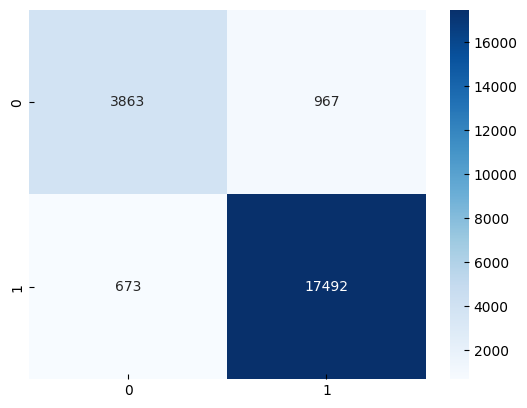

In [49]:
sns.heatmap(confusion_matrix(y_test, y_pred_rcv), annot=True, fmt='d', cmap='Blues')

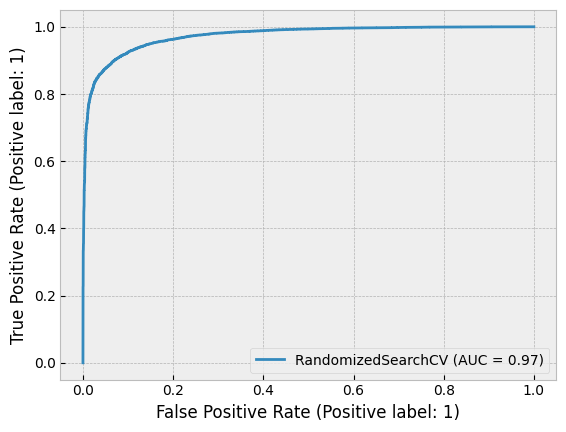

In [50]:
metrics.plot_roc_curve(rcv, x_test, y_test)

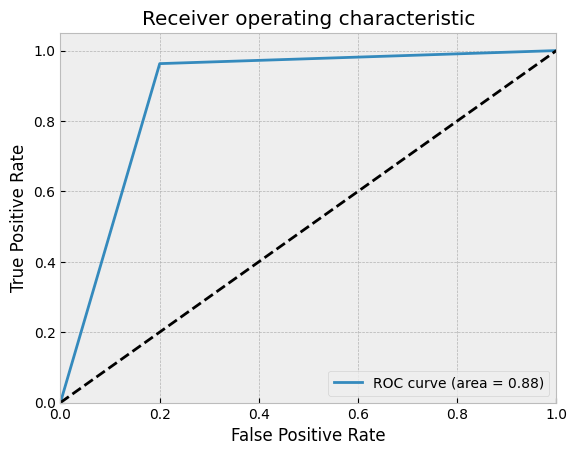

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rcv)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [52]:
# Testing the model on first two rows from our dataset
# 1 --> Won ; 0 --> Lost

new_sample = np.array([[54.151139, 30156308.0, 28.0, 5, 10.0, 2.00, 1500.0, 1670798778, 854.0]])
new_sample2 = np.array([[1135.387124, 30342192.0, 32.0, 0, 41.0, 0.68, 1220.0, 114611993, 931.0]])
new_pred = rcv.predict(new_sample)
print('Predicted Status:', (new_pred))

Predicted Status: [1]


In [53]:
df.head(2)

,index,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0
6,7,AA3F18A2-A7D6-43DE-8644-F0632AE2CB68,2021-04-01,113.387124,30342192.0,32.0,Won,W,41.0,0.68,1220.0,1000944,611993,2021-01-01,931.0


# Regression Problem

In [54]:
X = df[['index', 'quantity tons', 'customer', 'country', 'status', 'item type', 'application', 'thickness', 'width', 'product_ref']]
y = df['selling_price']

In [55]:
X['item type'] = X['item type'].map({'IPL':0, 'WI':1, 'Others':2, 'PL':3, 'S':4, 'W':5})
X['status'] = X['status'].map({'Lost':0, 'Won':1})

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
ss = StandardScaler()

x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

##### Linear Regression

In [58]:
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
y_pred_lin = lin_model.predict(x_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred_lin))
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred_lin))
print("R2 Score: ",r2_score(y_test, y_pred_lin))

Mean Squared Error:  14641.306511789599
Root Mean Squared Error:  121.00126657101403
Mean Absolute Error:  94.72596951694646
R2 Score:  0.5981104462733965


##### XGBRegresssor

In [59]:
xgb_reg = XGBRegressor(max_depth=10, learning_rate=0.5)
xgb_reg.fit(x_train, y_train)
y_pred_xgbr = xgb_reg.predict(x_test)

print("Mean Squared Error: ",mean_squared_error(y_test, y_pred_xgbr))
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_test, y_pred_xgbr)))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred_xgbr))
print("R2 Score: ",r2_score(y_test, y_pred_xgbr))

Mean Squared Error:  1999.5796860380838
Root Mean Squared Error:  44.71666005012096
Mean Absolute Error:  28.321223768764693
R2 Score:  0.9451134919540454


In [60]:
params_xgb_reg = {
    'max_depth': [4,6,8,10],
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'n_estimators': [50, 100, 300, 500, 1000]
}

rcv_xgb_reg = RandomizedSearchCV(estimator=XGBRegressor(),
                                 param_distributions = params_xgb_reg, cv=5)
rcv_xgb_reg.fit(x_train, y_train)
y_pred_reg = rcv_xgb_reg.predict(x_test)

print("Mean Squared Error: ",mean_squared_error(y_test, y_pred_reg))
print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_test, y_pred_reg)))
print("Mean Absolute Error: ",mean_absolute_error(y_test, y_pred_reg))
print("R2 Score: ",r2_score(y_test, y_pred_reg))

Mean Squared Error:  1695.726203159768
Root Mean Squared Error:  41.179196242274664
Mean Absolute Error:  25.27784500759761
R2 Score:  0.9534539730807747


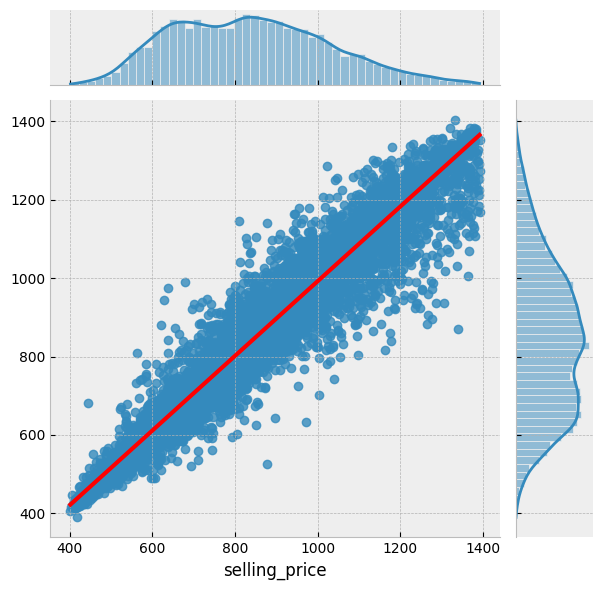

In [61]:
sns.jointplot(x=y_test, y = y_pred_reg, kind='reg', line_kws={'color':'red'} )

In [68]:
# Testing the Model by giving a sample data

new_sample = np.array([[0, 54.151139, 30156308.0, 28.0, 1, 5, 10.0, 2.00, 1500.0, 1670798778]])
#new_sample2 = np.array([[7, 1135.387124, 30342192.0, 32.0, 1, 5, 41.0, 0.68, 1220.0, 611993]])
new_pred = rcv_xgb_reg.predict(new_sample)
print('Predicted Status:', (new_pred))

Predicted Status: [609.31775]
